In [15]:
%reset -f
# reset all stored variables

### Importing necessary libraries

In [27]:
#numpy, pandas, matplotlib, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#PyTorch and it's sub modules
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn


### Pre-process the data

In [17]:
os.getcwd()

'/Users/mic/Desktop/-Math_108C-Final-Project'

In [41]:
Current_Directory=os.getcwd()
Image_Directory=os.path.join(Current_Directory, "data/", "data")
Image_Directory

'/Users/mic/Desktop/-Math_108C-Final-Project/data/data'

the size of the image is (218, 178, 3)


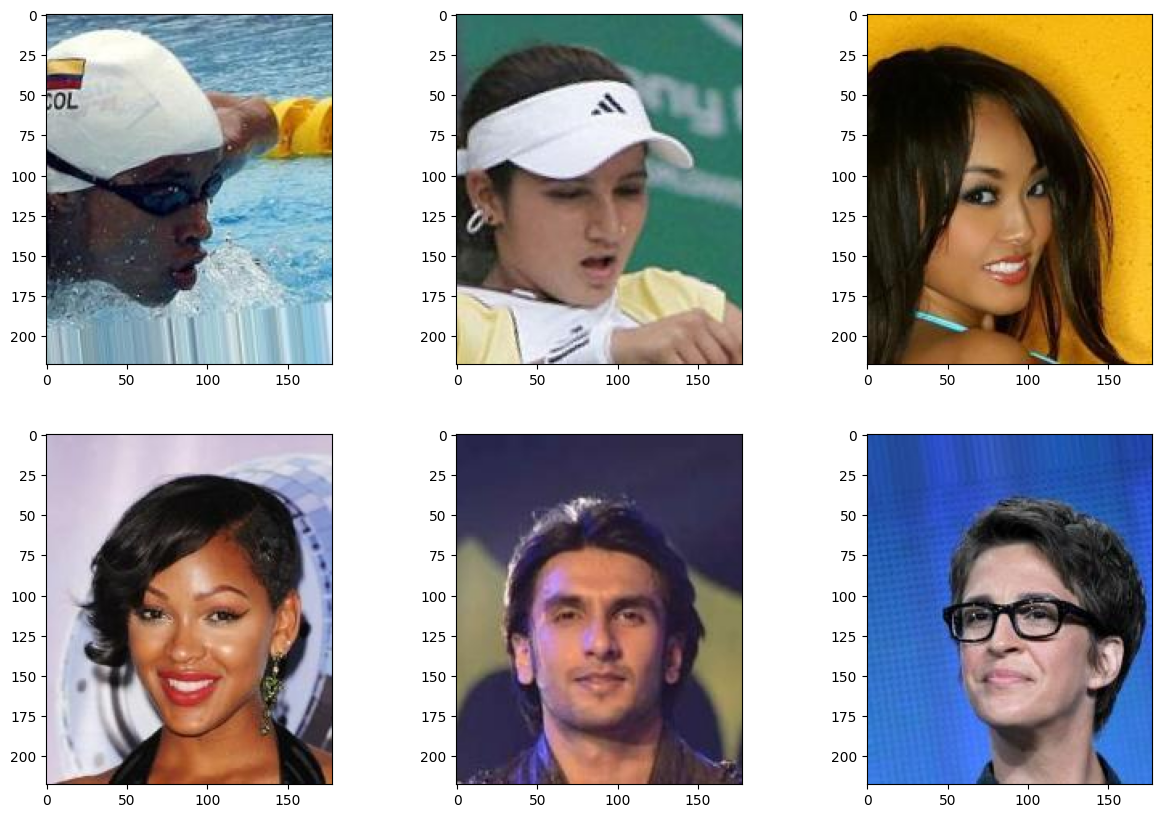

In [43]:
plt.figure(figsize=(15,10))
flag=0
for i in range(6):
        plt.subplot(2,3,i+1)
        choose_img_num=np.random.choice(os.listdir(Image_Directory))
        image_path=os.path.join(Image_Directory, choose_img_num)
        image=plt.imread(image_path)
        plt.imshow(image)
        
        if flag==0:
            print(f"the size of the image is {image.shape}")
            flag=1

In [102]:
train_transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()])
dataloader=DataLoader(dataset=torchvision.datasets.ImageFolder(os.path.join(Current_Directory, "data/"), transform=train_transform), batch_size=64)

In [103]:
all_features=[]
flag=1
for train_features, train_labels in dataloader:
    all_features.append(train_features)
    
    if flag==1:
        print(f"Feature batch shape: {train_features.shape}")
        flag=0

all_features=torch.cat(all_features, dim=0)
all_features.shape

Feature batch shape: torch.Size([64, 1, 218, 178])


torch.Size([5000, 1, 218, 178])

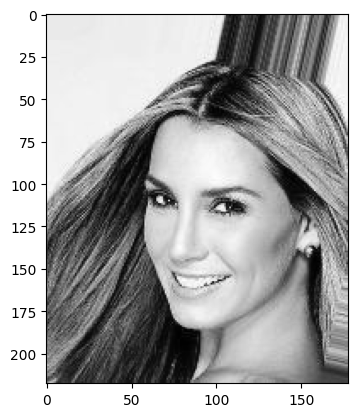

In [118]:
plt.imshow(all_features[0].squeeze(), cmap="gray")